### Student Name: Aidan Keeshan
### Student ID: 18200117

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import math
from sklearn.datasets.samples_generator import make_blobs
from sklearn.model_selection import train_test_split
import pandas as pd
#http://www.tarekatwan.com/index.php/2017/12/methods-for-testing-linear-separability-in-python/
#https://ieeexplore-ieee-org.proxy.lib.ul.ie/document/1603620

## Task 1 Import CSV

The first column of the source CSV has no title and is linear ascending integer from zero.    
I assume this was exported from pandas which exports the index unless specified otherwise.    
On import a new index was created and a field called 'Unnamed: 0' was in place or the original index.    
To remove redundancy I have set <font color='#0020C2'>index_col=['Unnamed: 0']</font> as appeared in <font color='#0020C2'>df.columns.values</font>.   
This may be unstable solution as undocumented, as far as I can see.   
It is not guaranteed the field name will be called that in all version of pandas.

In [2]:
df = pd.read_csv("bank_et1.csv",index_col=['Unnamed: 0'])
"|".join(df.columns.values)

'age|job|marital|education|default|balance|ratio_bal_ln|ratio_ln_inc|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|subscribed'

### Top 5 Records

In [3]:
df.head(5)

,age,job,marital,education,default,balance,ratio_bal_ln,ratio_ln_inc,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
0,32,technician,single,tertiary,no,392,1.300134,0.473895,yes,no,cellular,1,apr,957,2,131,2,failure,no
1,39,technician,divorced,secondary,no,688,-0.193701,0.237021,yes,yes,cellular,1,apr,233,2,133,1,failure,no
2,59,retired,married,secondary,no,1035,1.334266,0.121981,yes,yes,cellular,1,apr,126,2,239,1,failure,no
3,47,blue-collar,married,secondary,no,398,0.362286,1.251328,yes,yes,cellular,1,apr,274,1,238,2,failure,no
4,54,retired,married,secondary,no,1004,0.072075,-0.533738,yes,no,cellular,1,apr,479,1,307,1,failure,no


### Bottom 5 Records

In [4]:
df.tail(5)

,age,job,marital,education,default,balance,ratio_bal_ln,ratio_ln_inc,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,subscribed
1995,20,student,single,NaN,no,2785,-2.170524,1.081071,no,no,cellular,16,sep,327,2,-1,0,NaN,yes
1996,28,admin.,single,secondary,no,127,0.811788,1.134496,no,no,cellular,16,sep,1334,2,-1,0,NaN,yes
1997,81,retired,married,primary,no,1154,0.504655,0.042190,no,no,telephone,17,sep,231,1,-1,0,NaN,yes
1998,46,services,married,primary,no,4343,-0.965874,0.302708,yes,no,NaN,20,sep,185,1,-1,0,NaN,yes
1999,40,entrepreneur,married,secondary,no,6403,-0.800893,1.066659,no,no,cellular,22,sep,208,2,-1,0,NaN,yes


In [5]:
df.describe()

,age,balance,ratio_bal_ln,ratio_ln_inc,day,duration,campaign,pdays,previous
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,41.751500,1413.663500,0.241951,0.485030,13.851500,292.020500,1.909500,167.896000,2.561500
std,12.723077,3131.224213,0.821604,1.075543,9.712189,221.557295,1.378862,131.754126,3.400735
min,18.000000,-980.000000,-2.632068,-2.851405,1.000000,7.000000,1.000000,-1.000000,0.000000
25%,32.000000,201.500000,-0.308018,-0.274181,5.000000,146.000000,1.000000,75.750000,1.000000
50%,38.000000,551.000000,0.224099,0.487082,12.000000,236.000000,1.000000,182.000000,2.000000
75%,50.000000,1644.500000,0.806315,1.211896,23.000000,379.000000,2.000000,251.000000,3.000000
max,93.000000,81204.000000,2.961979,4.046914,31.000000,1823.000000,11.000000,854.000000,55.000000


In [6]:
nunique = df.nunique()
nunique = pd.DataFrame({'VARNAME' : nunique.index.values, 'VARNDIS': nunique.reset_index(drop=True)}).sort_values(by=['VARNDIS'])
nunique[nunique['VARNDIS']==2]

,VARNAME,VARNDIS
9,loan,2
10,contact,2
8,housing,2
4,default,2
18,subscribed,2


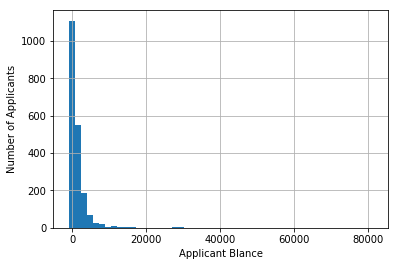

In [7]:
df['balance'].hist(bins=50)
plt.xlabel('Applicant Blance')
plt.ylabel('Number of Applicants')
plt.show()

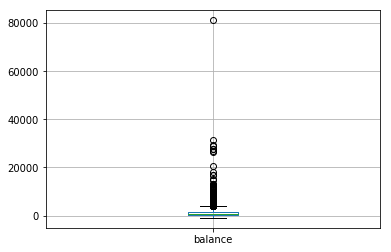

In [8]:
df.boxplot(column='balance')
plt.show()

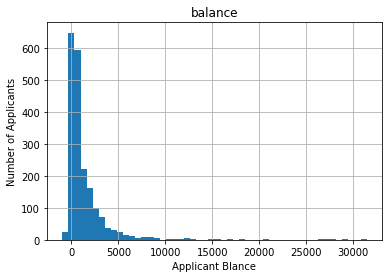

In [9]:
df[df['balance'] < 40000][['balance']].hist(bins=50)
plt.xlabel('Applicant Blance')
plt.ylabel('Number of Applicants')
plt.show()

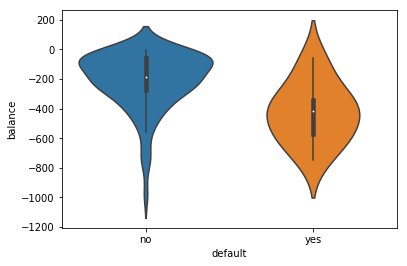

In [18]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import seaborn as sns

sns.violinplot(x='default', y='balance', data=df[df['balance'] < 0])
plt.show()

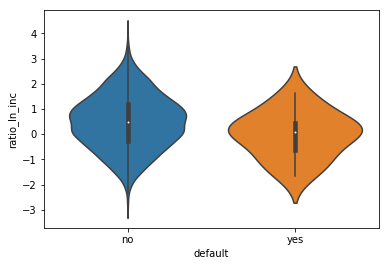

In [11]:
sns.violinplot(x='default', y='ratio_ln_inc',data=df)
plt.show()

Suggestion: try PLA on this dataset before using the bank dataset

In [12]:
X, y = make_blobs(n_samples=1000, centers=2, n_features=2)
y = [yy if yy == 1 else -1 for yy in y] 

In [13]:
def h(x,w):
    #Perceptron model: the sign of the dot product of weights and input vector determines the class allocation
    bias = np.array([1])
    return np.sign(w.T.dot(np.concatenate((bias,x))))

In [14]:
def point_on_boundary(weights, x):
    # Return the y-position on the boundary based on given x-position
    return -(weights[0]+weights[1]*x)/weights[2]

In [15]:
def decision_boundary(weights, x_min, x_max):
    # Return two points on the decision boundary
    return [pointOnBoundary(x_min), pointOnBoundary(x_max)]

In [23]:
def pla(training_in, training_out, weights):
    bias = np.array([1])
    iterations=0
    while True:
        errors = 0;
        for x,y in zip(training_in, training_out):
            if (h(x,weights)!=y):
                iterations+=1;
                weights = weights + y*(np.concatenate((bias,x)))
                errors+=1;
        if (errors == 0):
            break
    return weights, iterations

pla(df['balance'],df.default.map(dict(yes=1, no=-1)),np.zeros(df.count))

TypeError: expected sequence object with len >= 0 or a single integer

In [17]:
def calc_error(training_in, training_out, weights):
    # Calculate the classification error as the fraction of training samples that are misclassified
    errors=0
    for x,y in zip(training_in, training_out):
        if (h(x,weights)!=y):
            errors+=1;
    return errors/len(training_in)


Task

Use the below data set "bank-et1.csv" and the provided template notebook "Etivity1.ypynb" to complete the following tasks:
bank_et1.csv

Use git clone to get the template notebook from the following gitlab URL:

https://gitlab.com/mscai_sem1/group-2/etivity1.git

If you do not see a URL above this line, you are not currently in one of the StudentGroups. In this case please contact any of the moderators or module leaders as soon as possible. 
Task 1

Load bank-et1.csv into a Pandas dataframe. Examine the first few data rows and the last few data rows. Identify an attribute that can be the target/dependable variable for 2-class classification. Follow the examples in the provided notebook “Lab 1 - Exploratory Data Analysis. ipynb ” (see section Material, Resources and Online Meetings below).
Task 2

Follow the examples in the provided notebook “Lab 1 - Exploratory Data Analysis. ipynb ” (see section Material, Resources and Online Meetings below) to perform EDA of the bank data set.

    Calculate statistics for the numerical and categorical attributes.
    Use at least two different plotting techniques to plot the distribution of two numerical and two categorical attributes. Draw short conclusions (in a markdown cell).
    Generate two plots with the combined distribution of attributes and draw conclusions from them (in a markdown cell).
    Generate additional plots to identify two numerical attributes that can potentially be used for predicting the value of the dependent variable you chose in Task 1.
        You won't find two numerical attributes that will perfectly classify a dependent variable. Pick the best you can find.

Task 3

Consider the two numerical attributes picked in Task 2 and describe (in a markdown cell) how a perceptron can be used to perform 2-class classification. Use the following terms in your description:

    Input space
    Output space
    Unknown target function
    Data set
    Hypothesis set
    Final Hypothesis
    In-sample error
    Out-of-sample error

Task 4

Run the provided perceptron learning algorithm (PLA) on the dataset provided in the notebook. Take note of the number of iterations that were required to come to the final hypothesis and the final error. Once you are satisfied you understand these results, run the PLA algorithm on the dataset you have explored in the previous tasks (using the selected dependent variable and the two most promising numerical attributes/features). If results are unsatisfactory (if you don't get results at all, why would this be?), investigate how the PLA algorithm can be changed to improve the performance. Change the provided algorithm accordingly and plot estimates for P[Ein-Eout|>e]. Exercise 1.10 (see Python code below in the Resources section) gives an example of how you can create such plots. In the same plot add the Hoeffding Bound  and conclude whether or not the found results obey the Hoeffding Equation (in a markdown cell). Draw conclusions on whether or not you have found proof that learning is possible (in a markdown cell).

HINT: The videos discuss the 'Pocket' algorithm as an improvement on the PLA.
Post

Git push your notebook to the repository for E-tivity 1 and submit a post to the forum for E-tivity 1 with the following content:

    The names of the target variable you have chosen in Task 1 and the two numerical attributes you have chosen in Task 2. Your classification description required in Task 3.
    Summary (max 200 words) of the most interesting discoveries in the data set as result of performing EDA in Task 2.
    A link to your code in GitLab.

E-tivity 1: Exploratory Data Analysis & The Learning Problem
Respond

Respond to the post of one of your peers on the following aspects:

CS5062

    The quality of plots in their EDA
    The quality of conclusions drawn from their EDA
    Their classification description

CE6002

    Their implementation of the Pocket algorithm
    Their visualisation of the probability estimates
    Their choice of parameters used in the visualisation of the probability estimates

